> **Copyright &copy; 2020 CertifAI Sdn. Bhd.**<br>
 **Copyright &copy; 2021 CertifAI Sdn. Bhd.**<br>
 <br>
This program and the accompanying materials are made available under the
terms of the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). \
Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS, WITHOUT
WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the
License for the specific language governing permissions and limitations
under the License. <br>
<br>**SPDX-License-Identifier: Apache-2.0**> 

# 02 - Autoregressive Integrated Moving Average (ARIMA)

Revised by: [Kian Yang Lee](https://github.com/KianYang-Lee) - kianyang.lee@certifai.ai

## Notebook Description

This tutorial will showcase on how to apply **Auto Regressive Integrated Moving Average (ARIMA)** model. An exercise section is attached for you to practice and hone your skills. Do make good use of it.

By the end of this tutorial, you will be able to:

1. Understand the fundamentals of ARIMA model
2. Build and apply ARIMA model by choosing suitable parameters
3. Evaluate the performance of ARIMA models

## Notebook Outline
Below is the outline for this tutorial:
1. [Notebook Configurations](#configuration)
2. [Dataset](#dataset)
3. [Basic Analytics](#analytics)<br>
4. [Model Development](#model-dev)<br>
a. [Autoregressive Integrated Moving Average (ARIMA) Model](#arima) <br>
b. [Seasonal Autoregressive Integrated Moving Average (SARIMA) Model](#sarima)<br>
5. [Evaluation](#eval)
6. [Grid Search](#grid-search)
7. [Exercise](#exercise)
8. [Reference](#reference)
9. [Bonus](#bonus)

## <a name="configuration">Notebook Configurations</a>
Following are the modules that will be used for this tutorial. 

In [1]:
%matplotlib inline

from pathlib import Path
import sys
import statsmodels as sm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## <a name="dataset">Dataset</a>
The dataset to be used for this tutorial is the air passengers dataset. It contains monthly volume of air passengers in a particular airline.

In [2]:
# import data
airpassengers = pd.read_csv('../../datasets/decomposition/AirPassengers.csv')

# extract only "#passengers" column
airpassengers_series = pd.Series(airpassengers['#Passengers'].values, 
                            index = pd.date_range('1949-01', periods = len(airpassengers), freq='M'))

Since we are building a model, we need both training and test set, the former to build the model and the latter to validate the model performance. Let's get to work!

In [3]:
# split training and test data
airpassengers_train = airpassengers_series[:-24]
airpassengers_test = airpassengers_series[-24:]

## <a name="analytics">Basic Analytics</a>
Again, we are gonna stress that visualization is a great way to understand the data at our disposal. We will proceed to plot a time plot.

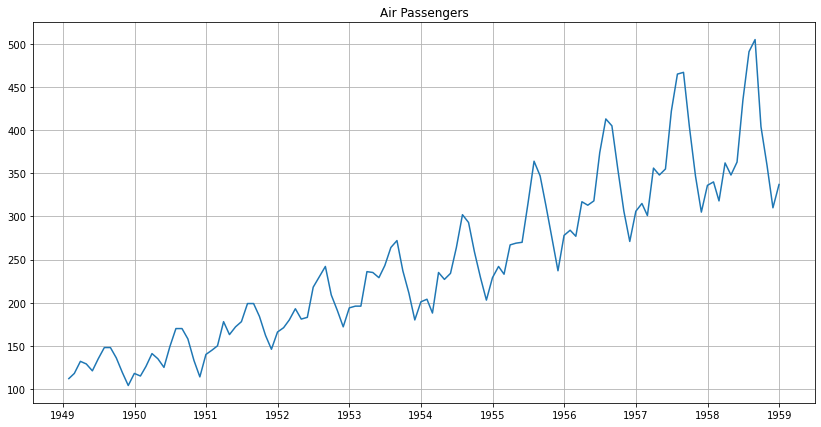

In [4]:
# generate time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(airpassengers_train)
plt.title('Air Passengers')
plt.show()

It is obviously not stationary. Let's validate this using ADF test.

In [5]:
def print_adf_result(adf_result):
    df_results = pd.Series(adf_result[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
    
    for key, value in adf_result[4].items():
        df_results['Critical Value (%s)'% key] = value
    print('Augmented Dickey-Fuller Test Results:')
    print(df_results)
    

result = adfuller(airpassengers_train, maxlag=12)
print_adf_result(result)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.201643
P-Value                   0.938325
# Lags Used              12.000000
# Observations Used     107.000000
Critical Value (1%)      -3.492996
Critical Value (5%)      -2.888955
Critical Value (10%)     -2.581393
dtype: float64


Nope, you are not stationary (yet). Let's apply seasonal differencing to remove the seasonal component from the data as ARIMA model expects that the time series is either not seasonal or has the seasonal component removed.

Text(0.5, 1.0, 'airpassengers')

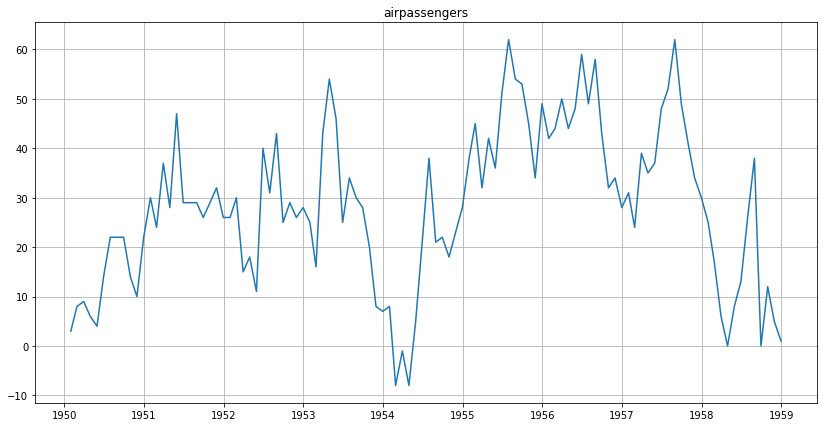

In [6]:
# seasonal differencing
airpassengers_season_diff_train = airpassengers_train.diff(12)

# plot time plot
plt.figure(figsize=(14,7))
plt.grid()
plt.plot(airpassengers_season_diff_train)
plt.title('airpassengers')

## <a name="model-dev">Model Development</a>
A total of two models will be discussed in this tutorial, which are ARIMA and SARIMA model.

### <a name="arima">Auto Regressive Integrated Moving Average (ARIMA) Model</a>
So what actually is **Auto Regressive Integrated Moving Average (ARIMA)**?<br><br>
Some of you might have guessed it, and it is a good guess. ARIMA is just a combination of AR (autoregressive) and MA (moving average) model, plus whatever "I" represents.<br><br>
"I" actually stands for "integrated", which means that it is the differencing operation performed prior to modelling. In short, ARIMA is the model that first applies differencing (if necessary) and then fit the data based on previous values (AR) and/or previous forecasted errors (MA). Whether which operation is applied and for how many terms is based on the order parameter that one assigns.

ARIMA has an order of **(p, d, q)**, where:
* p stands for the number of AR terms to regress against
* q stands for the number of MA terms to regress against
* d stands for the number of times differencing operation to be applied on the data prior to modelling

One thing to note is that ARIMA model assumes that the data is either not seasonal or has the seasonal component removed.

We will be using `statsmodels` module extensively for building MA model. You can read more about the module [here](https://www.statsmodels.org/).

In [7]:
#  Find d parameter for ARIMA
find_d = ARIMA(airpassengers_season_diff_train.dropna(), order=(0,0,0)).fit()
find_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(0, 0)   Log Likelihood                -453.118
Method:                           css   S.D. of innovations             16.064
Date:                Thu, 18 Mar 2021   AIC                            910.236
Time:                        12:41:28   BIC                            915.601
Sample:                    01-31-1950   HQIC                           912.411
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.2593      1.546     18.281      0.000      25.230      31.289
==============================================================================
"""

In [8]:
arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(1,0,1)).fit()
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:                     ARMA(1, 1)   Log Likelihood                -400.713
Method:                       css-mle   S.D. of innovations              9.840
Date:                Thu, 18 Mar 2021   AIC                            809.426
Time:                        12:41:29   BIC                            820.155
Sample:                    01-31-1950   HQIC                           813.776
                         - 12-31-1958                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.7950      5.425      4.755      0.000      15.163      36.428
ar.L1.y        0.8562      0.062     13.714      0.000       0.734       0.979
ma.L1.y       -0.1512      0.107     -1.408      0.159      -0.362       0.059
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1680           +0.0000j            1.1680            0.0000
MA.1            6.6125           +0.0000j            6.6125            0.0000
-----------------------------------------------------------------------------
"""

### Residual Analysis

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.


Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

In [9]:
residuals = pd.Series(arima.resid)

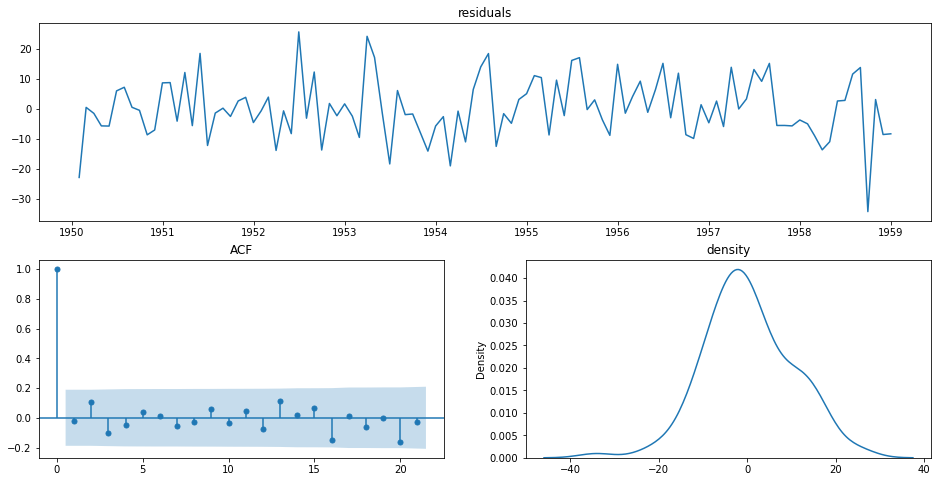

In [10]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)

In [11]:
arima_forecast, se, conf = arima.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_test.index)

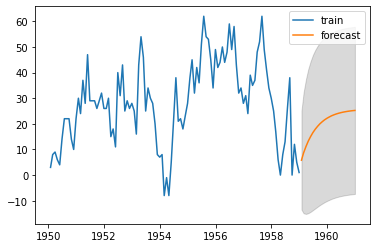

In [12]:
plt.plot(airpassengers_season_diff_train, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [13]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [14]:
# inverse differenced series back to original series
airpassengers_forecast_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, arima_forecast, 12)
airpassengers_lower_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, lower_series, 12)
airpassengers_upper_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, upper_series, 12)

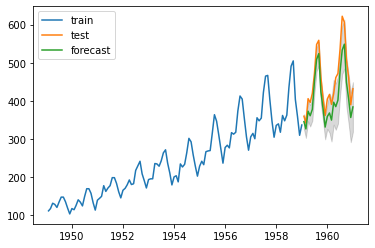

In [15]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, airpassengers_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

The values under *coef* are the weights of the respective terms. 

Akaike Information Criteria (AIC) and Bayesian Information Criteria (BIC) is to tell how good is the model. They are metrics that may be used to compare with other models. The lower the AIC, the better the model.

### <a name="sarima">Seasonal Autoregressive Integrated Moving Average (SARIMA) Model</a>
Seasonal Autoregressive Integrated Moving Average (SARIMA) is a method to forecast univariate time series with trend and seasonality. Building upon ARIMA, it has the ability to deal with time series with seaonality or seasonal component.

In [16]:
sarimax = SARIMAX(airpassengers_train, order=(3,1,1), seasonal_order=(0,1,0,12)).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  120
Model:             SARIMAX(3, 1, 1)x(0, 1, [], 12)   Log Likelihood                -397.385
Date:                             Thu, 18 Mar 2021   AIC                            804.771
Time:                                     12:41:33   BIC                            818.135
Sample:                                 01-31-1949   HQIC                           810.188
                                      - 12-31-1958                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5364      0.202      2.651      0.008       0.140       0.933
ar.L2          0.1857      0.145      1.277      0.202      -0.099       0.471
ar.L3         -0.1562      0.145     -1.074      0.283      -0.441       0.129
ma.L1         -0.7948      0.234     -3.400      0.001      -1.253      -0.337
sigma2        98.2491     13.823      7.107      0.000      71.156     125.342
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 2.55
Prob(Q):                              1.00   Prob(JB):                         0.28
Heteroskedasticity (H):               1.53   Skew:                            -0.09
Prob(H) (two-sided):                  0.21   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

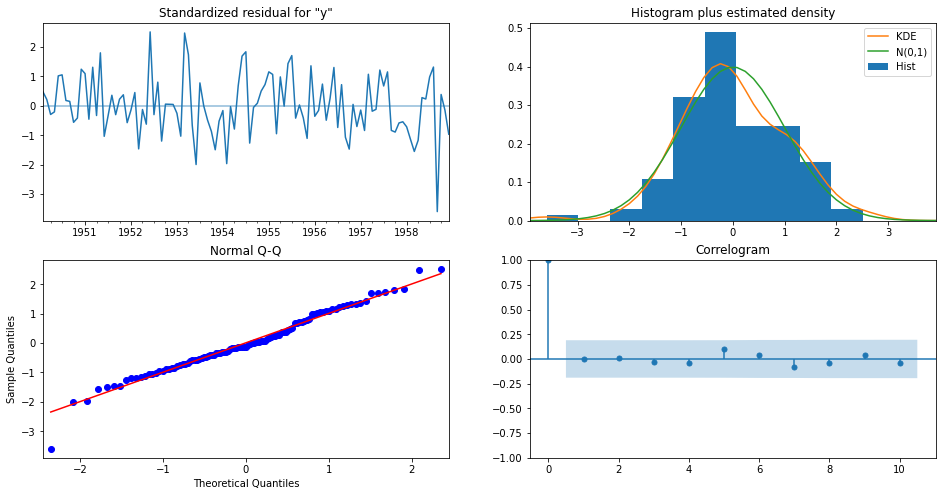

In [17]:
sarimax.plot_diagnostics(figsize=(16, 8))
plt.show()

In [18]:
sarimax_forecast = sarimax.get_forecast(24)
sarimax_forecast_conf_int = sarimax_forecast.conf_int()

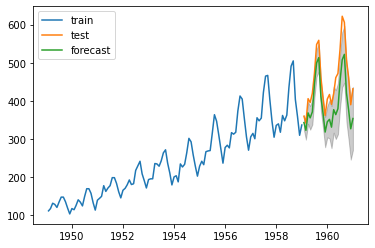

In [19]:
plt.plot(airpassengers_train, label='train')
plt.plot(airpassengers_test, label='test')
plt.plot(sarimax_forecast.predicted_mean, label='forecast')


plt.fill_between(sarimax_forecast_conf_int.index,
                 sarimax_forecast_conf_int.iloc[:, 0],
                 sarimax_forecast_conf_int.iloc[:, 1], color='k', alpha=.2)

plt.legend()


## <a name="res-analysis">Residual Analysis</a>

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:
- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.
- The residuals have constant variance.
- The residuals are normally distributed.


Any forecasting method that does not satisfy these properties can be improved. However, that does not mean that forecasting methods that satisfy these properties cannot be improved. It is possible to have several different forecasting methods for the same data set, all of which satisfy these properties. Checking these properties is important in order to see whether a method is using all of the available information, but it is not a good way to select a forecasting method.

In [20]:
residuals = pd.Series(arima.resid)

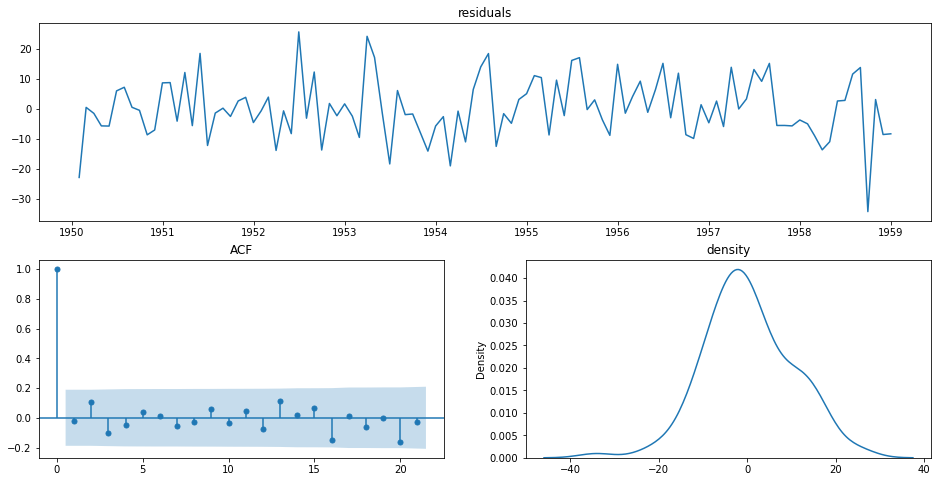

In [21]:
def check_residuals(series):
    fig = plt.figure(figsize=(16, 8))    
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(series)
    ax1.set_title('residuals')
    
    ax2 = fig.add_subplot(gs[1,0])
    plot_acf(series, ax=ax2, title='ACF')
    
    ax3 = fig.add_subplot(gs[1,1])
    sns.kdeplot(series, ax=ax3)
    ax3.set_title('density')
    
    plt.show()
    
check_residuals(residuals)

In [22]:
arima_forecast, se, conf = arima.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_test.index)

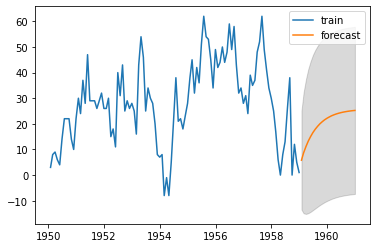

In [23]:
plt.plot(airpassengers_season_diff_train, label='train')
plt.plot(arima_forecast, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
plt.legend()

In [24]:
def inverse_differencing(orig_data, diff_data, interval):
    output = orig_data[:interval].tolist()
    for i in range(interval, len(diff_data)):
        output.append(output[i-interval] + diff_data[i])
    return output

def inverse_differencing_forecast(orig_series, diff_series, forecast_series, interval):
    series_merge = diff_series.append(forecast_series)
    inverse_diff_series = pd.Series(inverse_differencing(orig_series, series_merge, interval), 
                                    index=series_merge.index)
    return inverse_diff_series[-len(forecast_series):]

def train_test_forecast_plot(train_series, test_series, forecast_series, lower_upper=None):
    plt.plot(train_series, label = 'train')
    plt.plot(test_series, label = 'test')
    plt.plot(forecast_series, label = 'forecast')

    if lower_upper is not None:
        plt.fill_between(lower_upper[0].index, lower_upper[0], 
                     lower_upper[1], color='k', alpha=.15)
    plt.legend()

In [25]:
# inverse differenced series back to original series
airpassengers_forecast_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, arima_forecast, 12)
airpassengers_lower_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, lower_series, 12)
airpassengers_upper_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, upper_series, 12)

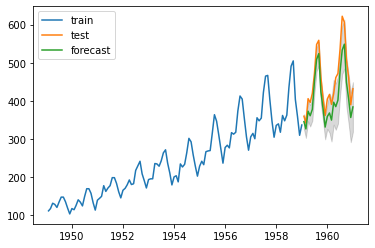

In [26]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, airpassengers_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

## <a name="eval">Evaluation</a>
Evaluation of the model can be done easily by computing the mean squared error (MSE) when predicted on test dataset. Of course, other metrics such as mean absolute error (MAE) and root mean squared error (RMSE) are also viable. But for the sake of demonstration, only MSE will be shown here.

In [27]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(airpassengers_test, airpassengers_forecast_series)
print('Test MSE: ', mse)

Test MSE:  2196.0629013257962


## <a name="grid-search">Grid Search</a>
Grid search is the process of performing exhaustive searching throughout a manually specified parameters in order to determine the optimal values for a given model.

For example, ARIMA has the parameters p, d, and q. we can manually specify range of values for parameters p, d, q, and build models based on the all the combination of parameters in p, d, and q. The measurement for the models can be in-sample error (AIC, BIC), or out-sample error (MSE). Finally, the model with the lowest error will be selected.

In [28]:
param_p = [0,1,2,3,4,5]
param_d = [0,1] # ARIMA only support two times of differencing
param_q = [0,1,2]

In [29]:
best_error, best_params, best_model = None, None, None

for p in param_p:
    for d in param_d:
        for q in param_q:
            try:
                arima = ARIMA(airpassengers_season_diff_train.dropna(), order=(p,d,q)).fit()
                if best_error is None or arima.aic < best_error:
                    best_error = arima.aic
                    best_params = (p,d,q)
                    best_model = arima
                print('ARIMA({},{},{}), AIC={}'.format(p,d,q, arima.aic))
            except:
                pass
print('Best Error={}, Best Params={}'.format(best_error, best_params))

ARIMA(0,0,0), AIC=910.2364820860948
ARIMA(0,0,1), AIC=859.1128781865842
ARIMA(0,0,2), AIC=828.5246316416847
ARIMA(0,1,0), AIC=809.6542460236442
ARIMA(0,1,1), AIC=805.6496003606308
ARIMA(0,1,2), AIC=807.6283595011007
ARIMA(1,0,0), AIC=809.3937465783121
ARIMA(1,0,1), AIC=809.4263830454563
ARIMA(1,0,2), AIC=809.5605918480013
ARIMA(1,1,0), AIC=805.2809094674408
ARIMA(1,1,1), AIC=806.8126968994866
ARIMA(2,0,0), AIC=808.8406195223565
ARIMA(2,0,1), AIC=809.650271077124
ARIMA(2,0,2), AIC=810.8559426311742
ARIMA(2,1,0), AIC=807.0927383370312
ARIMA(2,1,1), AIC=808.7922440795958
ARIMA(2,1,2), AIC=806.1953589118646
ARIMA(3,0,0), AIC=809.356145122656
ARIMA(3,0,1), AIC=811.2314792083669
ARIMA(3,0,2), AIC=810.6915702861257
ARIMA(3,1,0), AIC=807.0752100440753
ARIMA(3,1,1), AIC=806.771285766151
ARIMA(3,1,2), AIC=806.0101751666836
ARIMA(4,0,0), AIC=811.0125054424384
ARIMA(4,0,1), AIC=812.7557392583651
ARIMA(4,0,2), AIC=809.3569003830846
ARIMA(4,1,0), AIC=806.5985563765506
ARIMA(4,1,1), AIC=808.566381130

In [30]:
arima_forecast, se, conf = best_model.forecast(24)

arima_forecast = pd.Series(arima_forecast, index=airpassengers_test.index)
lower_series = pd.Series(conf[:, 0], index=airpassengers_test.index)
upper_series = pd.Series(conf[:, 1], index=airpassengers_test.index)

In [31]:
# inverse differenced series back to original series
airpassengers_forecast_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, arima_forecast, 12)
airpassengers_lower_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, lower_series, 12)
airpassengers_upper_series = inverse_differencing_forecast(airpassengers_train, airpassengers_season_diff_train, upper_series, 12)

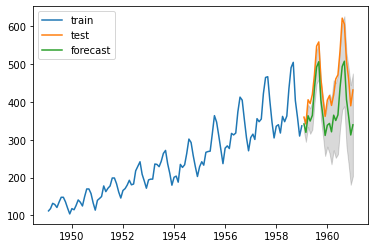

In [32]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, airpassengers_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])

## <a name="exercise">Exercise</a>

This exercise section is attached for you to practice and hone your skills. Try your best effort to complete it without referring to the solution.

### Notebook Configurations
**INSTRUCTIONS**: You can import any module that you wish to use for this exercise. However, if you run the cells from the start of this notebook, most probably all the modules which you need had already been imported at this point.

In [33]:
# import modules
### BEGIN SOLUTION


### END SOLUTION

### Dataset
**INSTRUCTIONS**: Please load the dataset into the environment using the path specified for you.

In [34]:
# specified path
dataset_path = Path().resolve().parent.parent/"datasets/others"
filename = "furniture-sales.csv"

In [35]:
# import dataset using specified path and filename above
### BEGIN SOLUTION

### END SOLUTION

### Basic Analytics
**INSTRUCTIONS**: Perform some basic analytics on the dataset by following the guidelines that are provided in each cell.

In [36]:
# display first 5 rows of data 
### BEGIN SOLUTION

### END SOLUTION

# setting DateTimeIndex since there is a datetime object conveniently 
### BEGIN SOLUTION



### END SOLUTION

# remove date column
### BEGIN SOLUTION

### END SOLUTION

# rename column
### BEGIN SOLUTION

### END SOLUTION

# convert to Series
### BEGIN SOLUTION

### END SOLUTION

# display current Series
### BEGIN SOLUTION

### BEGIN SOLUTION

# just extract and analyse data until the year 2006
### BEGIN SOLUTION

### END SOLUTION

# please perform a splitting to convert into train and test dataset
### BEGIN SOLUTION



### END SOLUTION

DATE
1992-01-01    3846
1992-02-01    3908
1992-03-01    4157
1992-04-01    4141
1992-05-01    4275
Freq: MS, dtype: int64


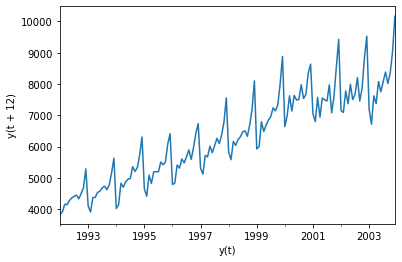

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -0.845726
P-Value                   0.805320
# Lags Used              14.000000
# Observations Used     129.000000
Critical Value (1%)      -3.482088
Critical Value (5%)      -2.884219
Critical Value (10%)     -2.578864
dtype: float64


In [37]:
# plot a time plot
### BEGIN SOLUTION

### END SOLUTION

# plot a lag plot for lag of 12
### BEGIN SOLUTION


### END SOLUTION

# perform ADF test
### BEGIN SOLUTION








### END SOLUTION

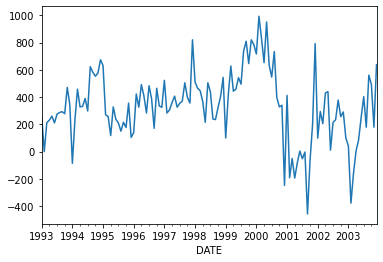

In [38]:
# seasonal differencing 
### BEGIN SOLUTION

### END SOLUTION

# display result after transformation
### BEGIN SOLUTION

### END SOLUTION

In [39]:
# inspect stationarity using ADF after differecing
### BEGIN SOLUTION


### END SOLUTION

Augmented Dickey-Fuller Test Results:
ADF Test Statistic       -3.408730
P-Value                   0.010665
# Lags Used              11.000000
# Observations Used     120.000000
Critical Value (1%)      -3.486056
Critical Value (5%)      -2.885943
Critical Value (10%)     -2.579785
dtype: float64


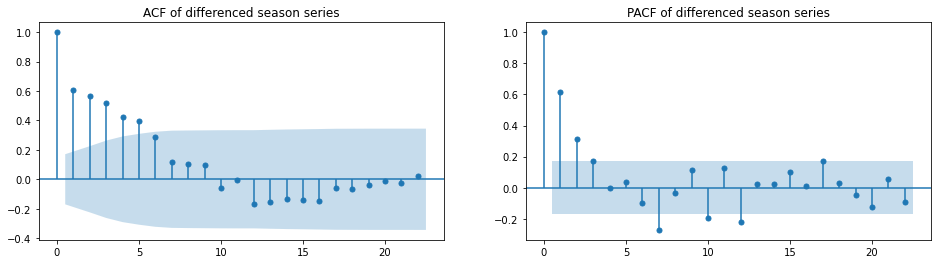

In [40]:
# inspect ACF and PACF to determine the hyperparameter to be used for ARIMA
### BEGIN SOLUTION








### END SOLUTION

### ARIMA Model Building
**INSTRUCTIONS**: Build ARIMA model using the provided data.

In [41]:
# building ARIMA model
### BEGIN SOLUTION

### END SOLUTION

# display summary of model
### BEGIN SOLUTION

### END SOLUTION

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  132
Model:                     ARMA(3, 3)   Log Likelihood                -873.908
Method:                       css-mle   S.D. of innovations            177.852
Date:                Thu, 18 Mar 2021   AIC                           1763.816
Time:                        12:42:12   BIC                           1786.878
Sample:                    01-01-1993   HQIC                          1773.187
                         - 12-01-2003                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        333.9000     68.944      4.843      0.000     198.772     469.027
ar.L1.y       -0.2818      0.059     -4.737      0.000      -0.398      -0.165
ar.L2.y        0.0088      0.065      0.136      0.892      -0.118       0.136
ar.L3.y        0.8590      0.057     15.157      0.000       0.748       0.970
ma.L1.y        0.7297      0.111      6.563      0.000       0.512       0.948
ma.L2.y        0.5759      0.126      4.576      0.000       0.329       0.823
ma.L3.y       -0.3814      0.105     -3.624      0.000      -0.588      -0.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -0.5811           -0.8203j            1.0053           -0.3481
AR.2           -0.5811           +0.8203j            1.0053            0.3481
AR.3            1.1519           -0.0000j            1.1519           -0.0000
MA.1           -0.5557           -0.8315j            1.0001           -0.3438
MA.2           -0.5557           +0.8315j            1.0001            0.3438
MA.3            2.6213           -0.0000j            2.6213           -0.0000
-----------------------------------------------------------------------------
"""

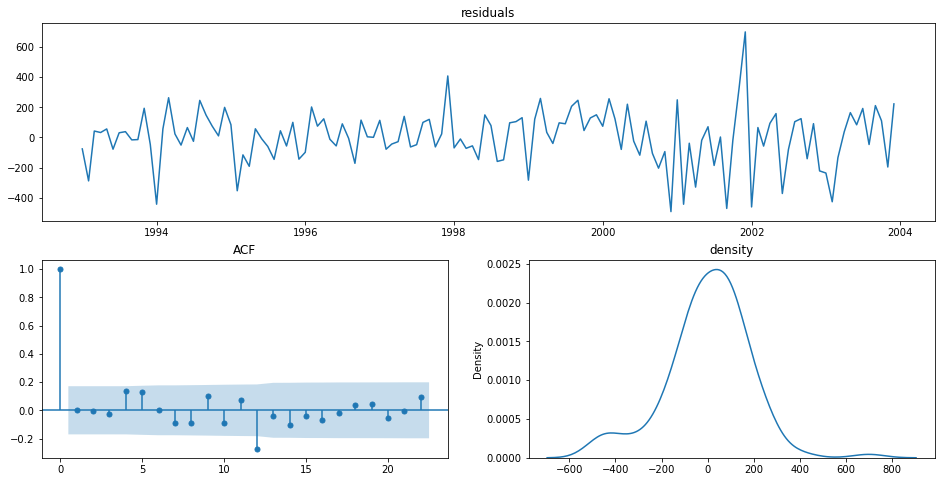

In [42]:
# residual analysis
### BEGIN SOLUTION













### END SOLUTION

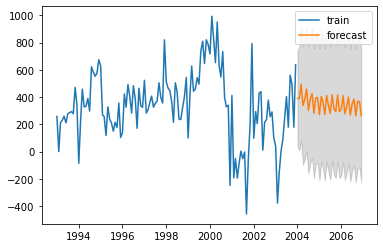

In [43]:
# perform forecast using the newly built ARIMA model
### BEGIN SOLUTION











### END SOLUTION

## <a name="reference">Reference</a>
1. [Statsmodels](www.statsmodels.org)

## <a name="bonus">Bonus</a>
R has a package which is known as `auto.arima` that are popular among time series practitioners. Some of its functionalities are showcased below.

In [44]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import joblib
sys.modules['sklearn.externals.joblib'] = joblib
import pmdarima as pm

auto_arima = pm.arima.auto_arima(airpassengers_train, m=12,
                            trace=True, seasonal=True,
                            error_action='ignore',  
                            suppress_warnings=True)


Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=813.749, BIC=835.206, Fit time=3.000 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=910.236, BIC=915.601, Fit time=0.040 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=810.646, BIC=821.375, Fit time=0.667 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=860.575, BIC=871.304, Fit time=0.539 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=809.411, BIC=817.458, Fit time=0.191 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 1, 12); AIC=810.721, BIC=821.449, Fit time=0.563 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 1, 12); AIC=812.509, BIC=825.920, Fit time=1.711 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=808.863, BIC=819.592, Fit time=0.212 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=809.672, BIC=823.082, Fit time=0.419 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 

In [45]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  120
Model:             SARIMAX(2, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -400.431
Date:                            Thu, 18 Mar 2021   AIC                            808.863
Time:                                    12:42:28   BIC                            819.592
Sample:                                         0   HQIC                           813.213
                                            - 120                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.2859      2.035      2.106      0.035       0.297       8.275
ar.L1          0.6783      0.100      6.816      0.000       0.483       0.873
ar.L2          0.1550      0.096      1.609      0.108      -0.034       0.344
sigma2        96.2826     11.855      8.121      0.000      73.046     119.519
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.93   Prob(JB):                         0.44
Heteroskedasticity (H):               1.41   Skew:                             0.02
Prob(H) (two-sided):                  0.31   Kurtosis:                         3.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [46]:
auto_arima_forecast = auto_arima.predict(n_periods=24)
auto_arima_forecast_series = pd.Series(auto_arima_forecast, index=airpassengers_test.index)

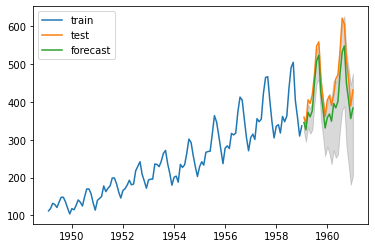

In [47]:
train_test_forecast_plot(airpassengers_train, airpassengers_test, auto_arima_forecast_series, 
                         [airpassengers_lower_series, airpassengers_upper_series])